<a href="https://colab.research.google.com/github/jayanth142006/potato-disease-classification-models/blob/main/DeiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision timm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Fix: Import the scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import timm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def load_dataset(folder_path, test_size=0.2, random_state=42):
    image_paths = []
    labels = []
    class_names = os.listdir(folder_path)

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image_paths.append(image_path)
            labels.append(label)

    # Split dataset into train and test sets
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=test_size, random_state=random_state
    )

    # Define transformations with data augmentation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Create datasets
    train_dataset = ImageDataset(train_paths, train_labels, transform=transform)
    test_dataset = ImageDataset(test_paths, test_labels, transform=transform)

    return train_dataset, test_dataset, class_names


In [ ]:
def create_deit_model(num_classes):
    # Initialize a pre-trained DeiT model
    model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=num_classes)
    return model


In [ ]:

def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-4, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Add weight decay
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)  # Add scheduler

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Evaluate on test set
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Adjust learning rate based on test accuracy
        scheduler.step(test_acc)

        # Print stats
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    # Plot the graphs
    plot_graphs(train_losses, train_accuracies, test_losses, test_accuracies)

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total

    return test_loss, test_acc

In [ ]:
def plot_graphs(train_losses, train_accuracies, test_losses, test_accuracies):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


Using device: cuda
Number of classes: 7
['Pest', 'Phytopthora', 'Virus', 'Bacteria', 'Fungi', 'Nematode', 'Healthy']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10: 100%|██████████| 340/340 [31:34<00:00,  5.57s/it]


Epoch 1/10
Train Loss: 0.5557, Train Acc: 80.60%
Test Loss: 0.3918, Test Acc: 86.69%


Epoch 2/10: 100%|██████████| 340/340 [05:45<00:00,  1.02s/it]


Epoch 2/10
Train Loss: 0.2271, Train Acc: 92.42%
Test Loss: 0.2659, Test Acc: 91.03%


Epoch 3/10: 100%|██████████| 340/340 [05:47<00:00,  1.02s/it]


Epoch 3/10
Train Loss: 0.1423, Train Acc: 95.24%
Test Loss: 0.2696, Test Acc: 90.96%


Epoch 4/10: 100%|██████████| 340/340 [05:47<00:00,  1.02s/it]


Epoch 4/10
Train Loss: 0.1050, Train Acc: 96.58%
Test Loss: 0.2144, Test Acc: 93.31%


Epoch 5/10: 100%|██████████| 340/340 [05:45<00:00,  1.02s/it]


Epoch 5/10
Train Loss: 0.0906, Train Acc: 96.97%
Test Loss: 0.1830, Test Acc: 93.31%


Epoch 6/10: 100%|██████████| 340/340 [05:48<00:00,  1.02s/it]


Epoch 6/10
Train Loss: 0.0662, Train Acc: 97.83%
Test Loss: 0.1353, Test Acc: 95.88%


Epoch 7/10: 100%|██████████| 340/340 [05:50<00:00,  1.03s/it]


Epoch 7/10
Train Loss: 0.0577, Train Acc: 98.18%
Test Loss: 0.1813, Test Acc: 94.26%


Epoch 8/10: 100%|██████████| 340/340 [05:50<00:00,  1.03s/it]


Epoch 8/10
Train Loss: 0.0455, Train Acc: 98.49%
Test Loss: 0.1461, Test Acc: 95.74%


Epoch 9/10: 100%|██████████| 340/340 [05:48<00:00,  1.03s/it]


Epoch 9/10
Train Loss: 0.0622, Train Acc: 97.90%
Test Loss: 0.2258, Test Acc: 92.79%


Epoch 10/10: 100%|██████████| 340/340 [05:47<00:00,  1.02s/it]


Epoch 10/10
Train Loss: 0.0672, Train Acc: 97.79%
Test Loss: 0.1960, Test Acc: 94.04%


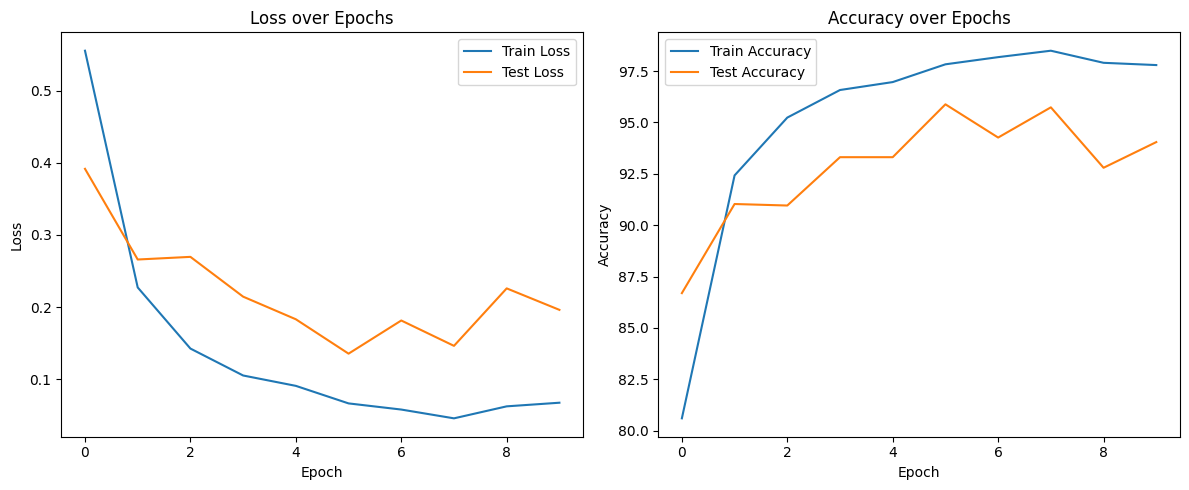

In [ ]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Load dataset
folder_path = '/content/drive/MyDrive/potato_dis_aug'  # Replace with your dataset path
train_dataset, test_dataset, class_names = load_dataset(folder_path)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Create ViT model
num_classes = len(class_names)
print(f'Number of classes: {num_classes}')
print(class_names)
model = create_deit_model(num_classes)
# Train the model
train_model(model, train_loader, test_loader, num_epochs=10, device=device)


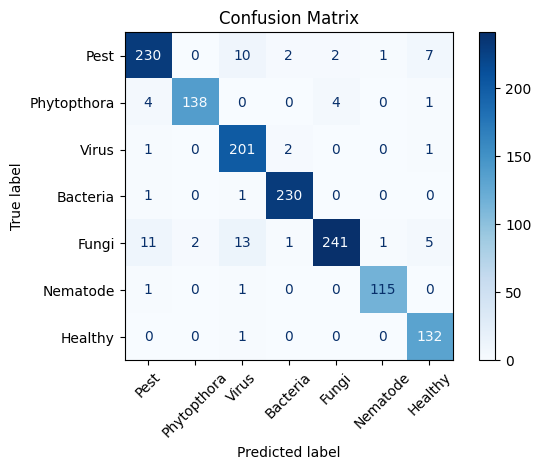

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, data_loader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# 🧩 Call this after training is done
plot_confusion_matrix(model, test_loader, class_names, device)


In [ ]:
!pip install --upgrade --no-cache-dir torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
import torch
print("CUDA:", torch.version.cuda)
print("cuDNN:", torch.backends.cudnn.version())
print("GPU:", torch.cuda.get_device_name(0))


CUDA: 12.4
cuDNN: 90100
GPU: Tesla T4
